In [1]:
from os.path import join as oj
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import data
from viz import *
import viz
from data import feats_numerical, feats_categorical, meta
%matplotlib inline
%load_ext autoreload
%autoreload 2

**load the data**

In [2]:
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=False, impute=True)
feats_binary = [feat for feat in common_feats
                if not feat in feats_numerical + feats_categorical + meta]
# df_pecarn = df_pecarn[df_pecarn.cv_fold.isin(data.pecarn_train_idxs)]
# df_psrc = df_psrc[df_psrc.cv_fold.isin(data.psrc_train_idxs)]

# see what feats matched / are missing

In [3]:
# matched feats
# for feat in common_feats:
#     print(feat, '\t', df_pecarn[feat].min(), '\t', df_pecarn[feat].max())
print('matched feats', list(filtered_feats_pecarn.intersection(filtered_feats_psrc)))

matched feats ['AbdTrauma_or_SeatBeltSign', 'DecrBreathSound', 'AbdDistention_or_AbdomenPain', 'GCSScore', 'InitHeartRate', 'Race', 'AbdDistention', 'MOI', 'Hypotension', 'RtCostalTender', 'ThoracicTrauma', 'Race_orig', 'Age<2', 'CostalTender', 'AbdTenderDegree', 'AbdTrauma', 'SeatBeltSign', 'AbdomenPain', 'GCSScore_Full', 'VomitWretch', 'LtCostalTender', 'DistractingPain', 'InitSysBPRange', 'Age']


In [4]:
print('psrc but not pecarn')
filtered_feats_psrc.difference(filtered_feats_pecarn)

psrc but not pecarn


{'FemurFracture'}

In [5]:
print('pecarn but not psrc')
print(filtered_feats_pecarn.difference(filtered_feats_psrc))

pecarn but not psrc
{'ThoracicTender', 'Sex'}


# look for feat shift

**continuous features**

In [ ]:
def plot_hist(data, kw={}, bins=None):
    if bins == 'unique':
        bins, counts = np.unique(data, return_counts=True)
#         print(bins, counts, bins.shape, counts.shape)
    elif bins is not None:
        counts, bins = np.histogram(data, bins=bins)
        bins = bins[:-1]
    else:
        counts, bins = np.histogram(data)
        bins = bins[:-1]
    height = (data.max() - data.min()) / bins.size * 0.9
        
    counts = counts / counts.sum() * 100
#     print(bins.shape, counts.shape)
    plt.barh(bins, counts, align='edge', height=height, **kw)
    
R, C, = 4, 1
plt.figure(figsize=(3, 12), dpi=500)
for i in range(len(feats_numerical)):
    ax = plt.subplot(R, C, i + 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    feat = sorted(feats_numerical)[i]
    kw1 = {
        'label': 'PECARN',
        'color': cb,
    }
    kw2 = {
        'label': 'PSRC',
        'color': cr,
        'alpha': 0.5
    }
    if feat == 'Age':
        plot_hist(df_pecarn[feat], kw1, bins=np.arange(19))
        plot_hist(df_psrc[feat], kw2, bins=np.arange(19))
        plt.yticks(np.array([0, 5, 10, 15, 17]) + 0.5,
                   labels=['0', '5', '10', '15', '17'], fontsize=13)
    elif feat == 'GCSScore':
        plot_hist(df_pecarn[feat], kw1, bins='unique') #, bins=np.arange(3, 16)-0.5) #, bins=np.arange(19))
        plot_hist(df_psrc[feat], kw2, bins='unique') #, bins=np.arange(3, 16)-0.5) #, bins=np.arange(19))
#         plt.hist(df_pecarn[feat], #bins=np.arange(15),
#                  alpha=1, label='pecarn', color=cb)
#         plt.hist(df_psrc[feat], #bins=np.arange(15),
#                  alpha=0.5, label='psrc', color=cr)
        plt.yticks(np.array([3, 6, 9, 12, 15]) + 0.5,
                   labels=['3', '6', '9', '12', '15'], fontsize=13)   
#         plt.ylim((2.5, 15.5))
    elif feat == 'InitHeartRate':
        plot_hist(df_pecarn[feat], kw1, bins=13)#, bins=np.arange(19))
        plot_hist(df_psrc[feat], kw2, bins=13)#, bins=np.arange(19))
        plt.yticks(fontsize=13)
    else:
        plot_hist(df_pecarn[feat], kw1, bins=13)#, bins=np.arange(19))
        plot_hist(df_psrc[feat], kw2, bins=24)#, bins=np.arange(19))        ]
        plt.ylim((0, 200))
        plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    def rename_local(x):
        rename_map = {
            'Age': 'Age (years)',
            'Heart rate': 'Heart rate (bpm)',
            'Systolic BP': 'Systolic blood pressure (mmHg)',
        }
        if x in rename_map:
            return rename_map[x]
        else:
            return x
    plt.ylabel(rename_local(viz.rename(feat)), fontsize=14, fontweight='bold')
    if i == R - 1:
        plt.xlabel('Study population (%)', fontsize=14)
#     plt.yticks([])
# plt.legend()
plt.tight_layout()
viz.savefig('matched_hists_continuous')
plt.show()

**categorical features**

In [ ]:
R, C = len(feats_categorical), 1
plt.figure(figsize=(6, 8), dpi=200)
# print(feats_categorical)
for i in range(R):
    plt.subplot(R, C, i + 1)
    feat = feats_categorical[i]
    vals_unique = np.unique(np.hstack((df_pecarn[feat], df_psrc[feat]))).tolist()
    print(vals_unique)
    n = len(vals_unique)
    frac_pecarn = np.array([(df_pecarn[feat]==val).sum() for val in vals_unique]) / df_pecarn.shape[0] * 100
    frac_psrc = np.array([(df_psrc[feat]==val).sum() for val in vals_unique]) / df_psrc.shape[0] * 100
    
    width = 0.4
    plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
    plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
    plt.yticks(np.arange(n) - width + 0.2, [v.replace('unknown', 'Unknown') for v in vals_unique])


    plt.xticks(rotation='vertical')
    def rename_local(x):
        rename_map = {
            'Abd. tenderness\ndegree': 'Degree of\nabdominal tenderness',
            'MOI': 'Mechanism of Injury',
        }
        if x in rename_map:
            return rename_map[x]
        else:
            return x
    plt.ylabel(rename_local(viz.rename(feat)), fontweight='bold', fontsize=13)
    if i == R - 1:
        plt.xlabel('Study population (%)')    

# plt.legend()
plt.tight_layout()
viz.savefig('matched_hists')
plt.show()

**binary feats**

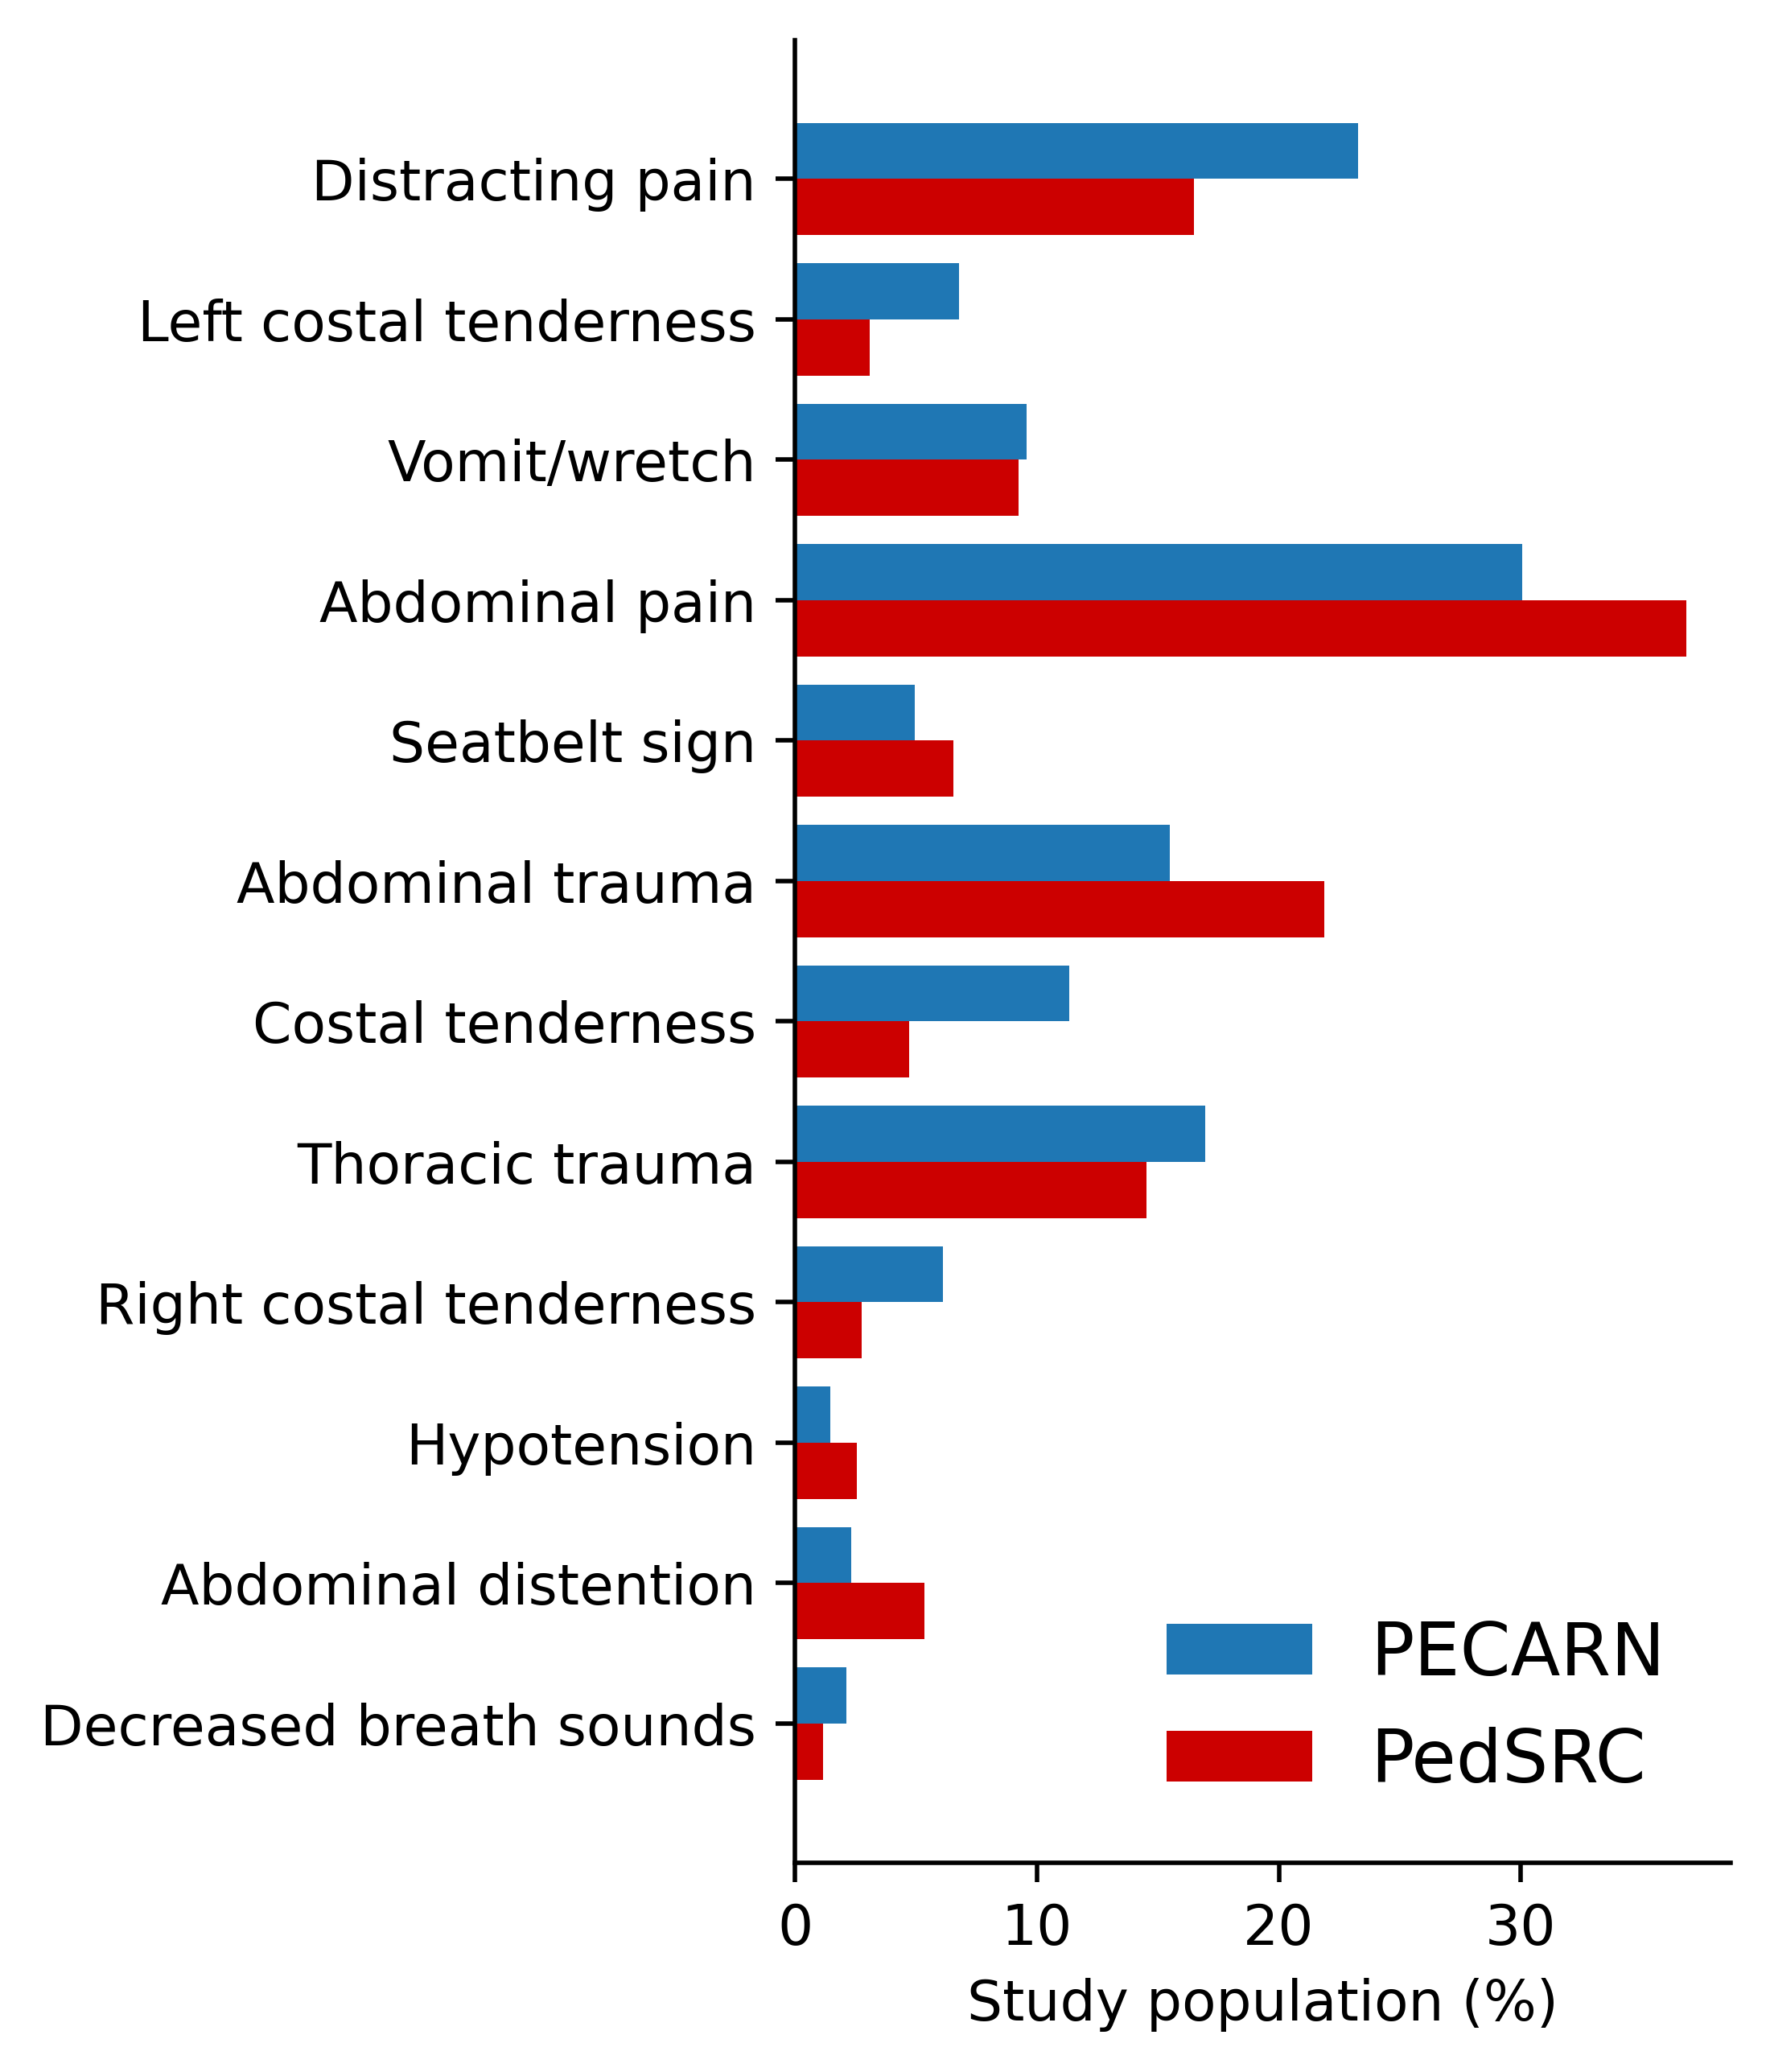

In [31]:
R, C = 3, 4
feats_binary_plot = [f for f in feats_binary
                     if not '_or_' in f
                     and not 'Race_orig' in f
                     and not 'GCSScore_Full' in f
                     and not '<' in f]
n = len(feats_binary_plot)
def true_or_yes(vals):
    return (vals==True) | (vals=='yes')
frac_psrc = true_or_yes(df_psrc[feats_binary_plot]).mean().values * 100
frac_pecarn = true_or_yes(df_pecarn[feats_binary_plot]).mean().values * 100

width = 0.4
plt.figure(dpi=500, figsize=(3, 6))
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='PECARN', color=cb)
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='PedSRC', color=cr)
def rename_local(x):
    rename_map = {
        'Abd. pain': 'Abdominal pain',
        'Abd. trauma': 'Abdominal trauma',        
        'Abd. distention': 'Abdominal distention',   
        'Decr. breath sounds': 'Decreased breath sounds'
    }
    if x in rename_map:
        return rename_map[x]
    else:
        return x
plt.yticks(np.arange(n) - width + 0.2,
           [rename_local(viz.rename(f)) for f in feats_binary_plot])
plt.xlabel('Study population (%)')
plt.legend(frameon=False, fontsize=13)
plt.show()

**missing features**

In [ ]:
R, C = 3, 4
feats_all = [feat for feat in common_feats
         if not feat in meta]
n = len(feats_all)
frac_psrc = (df_psrc[feats_all]=='unknown').mean().values
frac_pecarn = (df_pecarn[feats_all]=='unknown').mean().values

width = 0.4
plt.figure(dpi=300, figsize=(3, 6))
plt.xlabel('Fraction of patients\nmissing this feature')
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
plt.yticks(np.arange(n) - width + 0.2, feats_all)

plt.legend()
plt.show()

**write csvs**

In [6]:
df_pecarn.astype('object').describe().transpose().to_csv('processed/pecarn_vars.csv')
df_psrc.astype('object').describe().transpose().to_csv('processed/psrc_vars.csv')

# how are vars related to outcome

In [7]:
def get_risks(df, feat, vals_unique, outcome='iai_intervention'):
    '''Return iai with intervention as a percentage
    '''
    risks = []
    for val in vals_unique:
        risks.append(df[df[feat]==val][outcome].mean())
    return np.array(risks) * 100

In [ ]:
feats = feats_categorical
R, C = len(feats), 1
plt.figure(figsize=(6, 21), dpi=200)

# feats = ['Sex', 'Age_discrete']
# plt.figure(figsize=(6, 8), dpi=200)


def agecut(age): # inclusive on right end
    return pd.cut(age, bins=(-1, 4, 9, 1000), labels=['<5', '5-9', '>9'])
df_psrc['Age_discrete'] = agecut(df_psrc['Age'])
df_pecarn['Age_discrete'] = agecut(df_pecarn['Age'])


for i in range(R):
    WIDTH = 0.4
    plt.subplot(R, C, i + 1)
    feat = feats[i]
    
    # get unique values
    if feat in df_psrc.keys(): # need to check bc Sex is not there
        vals_unique = list(set(df_pecarn[feat].unique().tolist() + df_psrc[feat].unique().tolist()))
    else:
        vals_unique = np.unique(df_pecarn[feat]).tolist()
        WIDTH = 0.2
    n = len(vals_unique)
    
    # plot pecarn
    risks = get_risks(df_pecarn, feat, vals_unique)
    plt.barh(np.arange(n), risks, height=0.4, label='pecarn', color=cb) #, color=cb)
    plt.yticks(np.arange(n) - WIDTH + 0.2, vals_unique, fontsize=18)
    plt.xlabel('IAI-I Risk (%)', fontsize=18)
    plt.xticks(rotation='vertical')
    plt.title(feat, fontsize=18)
    
    if feat in df_psrc.keys(): # need to check bc Sex is not there
        risks = get_risks(df_psrc, feat, vals_unique)
        plt.barh(np.arange(n) - WIDTH, risks, height=0.4, label='psrc', color=cr) #, color=cr)

plt.legend(fontsize=18)
plt.tight_layout()
plt.show()